In [3]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# COVID-19 Cases Data
Load and prepare COVID-19 cases data taken from [*The New York Times*](https://https://github.com/nytimes/covid-19-data). Calculate case growth ratio for any county *c* on a day *t* where *c* is the number of new cases reported in that county on that day. And graph case growth ratios.


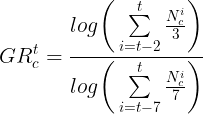








## Load and Clean Data

In [4]:
cases_url = "./data/nyt_covid_dataset.csv"
df_cases = pd.read_csv(cases_url, parse_dates=[0])
df_cases.tail()

,date,county,state,fips,cases,deaths
907533,2021-01-07,Sweetwater,Wyoming,56037.0,3108,24.0
907534,2021-01-07,Teton,Wyoming,56039.0,2260,4.0
907535,2021-01-07,Uinta,Wyoming,56041.0,1668,8.0
907536,2021-01-07,Washakie,Wyoming,56043.0,793,21.0
907537,2021-01-07,Weston,Wyoming,56045.0,483,4.0


In [5]:
# only keep data in the year 2020
df_cases = df_cases[df_cases['date'] <= '2020-12-31']
df_cases.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 884817 entries, 0 to 884816
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    884817 non-null  datetime64[ns]
 1   county  884817 non-null  object        
 2   state   884817 non-null  object        
 3   fips    876510 non-null  float64       
 4   cases   884817 non-null  int64         
 5   deaths  866056 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 47.3+ MB


### Fix metropolitan areas

Count which counties have null FIPs. Note that some cases do not have a county assigned to them because the data scientists that collected the data are not sure exactly which county the positive tests came from. Other rows that have a null FIPs identification, such as New York City and Kansas City, are an amalagation of several counties into one metropolitan area.

Let's give these metropolitan areas FIPs codes. \\
Rhode Island: 44002 \\
New York City: 36061 \\
Kansas City: 29095 \\
Joplin: 29375

In [6]:
df_cases.loc[((df_cases['county'] == 'Unknown') & (df_cases['state'] == 'Rhode Island')), 'fips'] = 44002
df_cases.loc[df_cases['county'] == 'New York City', 'fips'] = 36061
df_cases.loc[df_cases['county'] == 'Kansas City', 'fips'] = 29095
df_cases.loc[df_cases['county'] == 'Joplin', 'fips'] = 29375
df_cases.shape
df_cases[df_cases['county'] == 'New York City']

,date,county,state,fips,cases,deaths
416,2020-03-01,New York City,New York,36061.0,1,0.0
448,2020-03-02,New York City,New York,36061.0,1,0.0
482,2020-03-03,New York City,New York,36061.0,2,0.0
518,2020-03-04,New York City,New York,36061.0,2,0.0
565,2020-03-05,New York City,New York,36061.0,4,0.0
...,...,...,...,...,...,...
870465,2020-12-27,New York City,New York,36061.0,413472,24973.0
873710,2020-12-28,New York City,New York,36061.0,416922,25008.0
876955,2020-12-29,New York City,New York,36061.0,422074,25055.0
880200,2020-12-30,New York City,New York,36061.0,426279,25099.0


### Remove unusable data from dataset

Remove all U.S. territories from the dataset.

In [7]:
# drop Guam, Virgin Islands, Puerto Rico, and Northern Mariana Islands
territories = ['Guam', 'Virgin Islands', 'Puerto Rico', 'Northern Mariana Islands']
df_cases = df_cases[~df_cases['state'].isin(territories)]
df_cases[df_cases['state'] == 'Northern Mariana Islands']

,date,county,state,fips,cases,deaths


Look at the remaining rows with null fips and no known county. This data cannot be used.

In [8]:
null_rows = df_cases[df_cases['fips'].isnull()]
print("Rows without a known county")
print("---------------------------")
print(null_rows.head())
print("...")
print(null_rows.tail())
print()

print("earliest date: " + np.str(min(null_rows['date'])) + "     latest date: " + np.str(max(null_rows['date'])))
print()

print("Table of dates after April 1st")
print("------------------------------")
print(null_rows[null_rows['date'] > '2020-04-01']['state'].value_counts())
print()

null_rows_bystate = null_rows.groupby(['state', 'county']).agg({'cases': 'max', 'deaths': 'max'}).reset_index()
print("Rows without a known county by state")
print("------------------------------------")
print(null_rows_bystate)
print("total number of cases unaccounted: " + str(null_rows_bystate['cases'].sum()))

Rows without a known county
---------------------------
           date   county       state  fips  cases  deaths
1511 2020-03-12  Unknown  New Jersey   NaN      1     0.0
1804 2020-03-13  Unknown  New Jersey   NaN      1     0.0
2151 2020-03-14  Unknown  New Jersey   NaN      1     0.0
2559 2020-03-15  Unknown  New Jersey   NaN      1     0.0
2929 2020-03-16  Unknown       Maine   NaN      1     0.0
...
             date   county         state  fips  cases  deaths
883624 2020-12-31  Unknown  North Dakota   NaN      7     7.0
883791 2020-12-31  Unknown      Oklahoma   NaN    236     0.0
884184 2020-12-31  Unknown     Tennessee   NaN   6903    59.0
884471 2020-12-31  Unknown          Utah   NaN    430     2.0
884488 2020-12-31  Unknown       Vermont   NaN      9     0.0

earliest date: 2020-03-12 00:00:00     latest date: 2020-12-31 00:00:00

Table of dates after April 1st
------------------------------
Connecticut       274
Vermont           274
Arkansas          274
Louisiana         

In [9]:
df_cases = df_cases.dropna(axis=0, how='any')

### Fix FIPS codes

In [10]:
df_cases['fips'] = df_cases['fips'].astype(np.int64)
df_cases['fips'] = df_cases['fips'].astype(np.str)
df_cases['fips'] = df_cases['fips'].str.zfill(5)

## Calculate Growth Ratios

In [11]:
# compute new cases per day
df_cases['new_cases'] = df_cases.groupby('fips', as_index=False)['cases'].diff()
df_cases = df_cases[(df_cases['new_cases'].notna())]
df_cases[(df_cases['fips'] == '01001') & (df_cases['new_cases'] == 0)]

,date,county,state,fips,cases,deaths,new_cases
14025,2020-03-27,Autauga,Alabama,01001,6,0.0,0.0
15803,2020-03-28,Autauga,Alabama,01001,6,0.0,0.0
17686,2020-03-29,Autauga,Alabama,01001,6,0.0,0.0
21727,2020-03-31,Autauga,Alabama,01001,7,0.0,0.0
26101,2020-04-02,Autauga,Alabama,01001,10,0.0,0.0
30753,2020-04-04,Autauga,Alabama,01001,12,0.0,0.0
33157,2020-04-05,Autauga,Alabama,01001,12,0.0,0.0
35596,2020-04-06,Autauga,Alabama,01001,12,1.0,0.0
38084,2020-04-07,Autauga,Alabama,01001,12,1.0,0.0
40626,2020-04-08,Autauga,Alabama,01001,12,1.0,0.0


In [12]:
df_cases_bycounty = df_cases.groupby('fips', as_index=False)

#### Calculate Growth Ratio 7 Day
This growth ratio has a 7 day baseline.

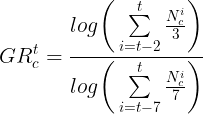

In [13]:
growth_rate_7day = np.log(df_cases_bycounty['new_cases'].rolling(3).sum() / 3) / np.log(df_cases_bycounty['new_cases'].rolling(7).sum() / 7)
growth_rate_7day = growth_rate_7day.reset_index().rename(columns={'new_cases': 'growth_rate_7day', 'level_1': 'index'}).set_index('index')
growth_rate_7day[growth_rate_7day['fips'] == '01001'].tail()

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,fips,growth_rate_7day
index,,
868592,01001,0.905905
871837,01001,0.868422
875082,01001,0.982035
878327,01001,1.036994
881572,01001,1.045461


#### Calculate Growth Ratio 14 Day
This growth ratio has a 14 day baseline.

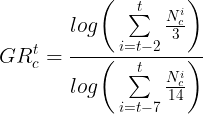

In [14]:
growth_rate_14day = np.log(df_cases_bycounty['new_cases'].rolling(3).sum() / 3) / np.log(df_cases_bycounty['new_cases'].rolling(14).sum() / 14)
growth_rate_14day = growth_rate_14day.reset_index().rename(columns={'new_cases': 'growth_rate_14day', 'level_1': 'index'}).set_index('index')
growth_rate_14day[growth_rate_14day['fips'] == '01001'].tail()

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,fips,growth_rate_14day
index,,
868592,01001,0.851916
871837,01001,0.812402
875082,01001,0.918400
878327,01001,0.990274
881572,01001,0.983918


In [15]:
df_cases = df_cases.assign(growth_rate_7day = growth_rate_7day['growth_rate_7day'])
df_cases = df_cases.assign(growth_rate_14day = growth_rate_14day['growth_rate_14day'])

df_cases['growth_rate_7day'] = df_cases['growth_rate_7day'].replace([np.inf, -np.inf], np.nan)
df_cases['growth_rate_14day'] = df_cases['growth_rate_14day'].replace([np.inf, -np.inf], np.nan)

df_cases[(df_cases['fips'] == '01001') & (df_cases['date'] >= '2020-12-01') & (df_cases['date'] <= '2020-12-14')]

,date,county,state,fips,cases,deaths,new_cases,growth_rate_7day,growth_rate_14day
784210,2020-12-01,Autauga,Alabama,01001,2818,42.0,38.0,1.067482,1.069680
787454,2020-12-02,Autauga,Alabama,01001,2873,42.0,55.0,1.127910,1.157367
790700,2020-12-03,Autauga,Alabama,01001,2893,42.0,20.0,1.101018,1.138638
793946,2020-12-04,Autauga,Alabama,01001,2945,42.0,52.0,1.073904,1.148653
797191,2020-12-05,Autauga,Alabama,01001,2979,42.0,34.0,1.003821,1.078172
800437,2020-12-06,Autauga,Alabama,01001,3005,42.0,26.0,1.007925,1.089688
803683,2020-12-07,Autauga,Alabama,01001,3043,42.0,38.0,0.961423,1.033099
806928,2020-12-08,Autauga,Alabama,01001,3087,42.0,44.0,0.982109,1.049229
810173,2020-12-09,Autauga,Alabama,01001,3117,42.0,30.0,1.019325,1.056269
813417,2020-12-10,Autauga,Alabama,01001,3186,42.0,69.0,1.034805,1.091934


### Calculate Growth Ratio (Rate of Change)

In [16]:
previous_3days = df_cases_bycounty['new_cases'].rolling(3).sum() / 3
previous_7days = df_cases_bycounty['new_cases'].rolling(7).sum() / 7
new_cases_relative_rate_change = previous_3days - previous_7days
new_cases_relative_rate_change = new_cases_relative_rate_change.reset_index().rename(columns={'new_cases': 'new_cases_relative_rate_change', 'level_1': 'index'}).set_index('index')
new_cases_relative_rate_change

,fips,new_cases_relative_rate_change
index,,
10835,01001,NaN
12367,01001,NaN
14025,01001,NaN
15803,01001,NaN
17686,01001,NaN
...,...,...
871836,56045,-0.857143
875081,56045,-0.523810
878326,56045,1.047619


In [17]:
df_cases = df_cases.assign(new_cases_relative_rate_change = new_cases_relative_rate_change['new_cases_relative_rate_change'])
df_cases['new_cases_relative_rate_change_shift7'] = df_cases['new_cases_relative_rate_change'].shift(7)
df_cases.tail(10)

,date,county,state,fips,cases,deaths,new_cases,growth_rate_7day,growth_rate_14day,new_cases_relative_rate_change,new_cases_relative_rate_change_shift7
884807,2020-12-31,Niobrara,Wyoming,56027,140,2.0,0.0,NaN,NaN,-0.428571,-10.714286
884808,2020-12-31,Park,Wyoming,56029,2021,10.0,36.0,1.055051,1.080591,4.333333,-0.809524
884809,2020-12-31,Platte,Wyoming,56031,440,8.0,6.0,1.611889,1.680144,3.190476,-0.619048
884810,2020-12-31,Sheridan,Wyoming,56033,2543,17.0,22.0,1.032208,1.153543,1.476190,-4.476190
884811,2020-12-31,Sublette,Wyoming,56035,597,6.0,5.0,1.375686,1.157859,1.095238,-2.666667
884812,2020-12-31,Sweetwater,Wyoming,56037,2966,16.0,23.0,0.891481,0.868008,-5.857143,3.809524
884813,2020-12-31,Teton,Wyoming,56039,2138,4.0,17.0,0.869159,0.935702,-4.142857,2.809524
884814,2020-12-31,Uinta,Wyoming,56041,1558,7.0,18.0,1.145691,1.095305,5.142857,-0.428571
884815,2020-12-31,Washakie,Wyoming,56043,780,19.0,13.0,0.869186,0.847355,-1.857143,4.333333
884816,2020-12-31,Weston,Wyoming,56045,476,2.0,1.0,1.328947,1.100231,0.714286,3.190476


In [18]:
df_cases['growth_rate_of_change'] = df_cases['new_cases_relative_rate_change'] / df_cases['new_cases_relative_rate_change_shift7']
df_cases['growth_rate_of_change'] = df_cases['growth_rate_of_change'].replace([np.inf, -np.inf], np.nan)
df_cases.tail(10)

,date,county,state,fips,cases,deaths,new_cases,growth_rate_7day,growth_rate_14day,new_cases_relative_rate_change,new_cases_relative_rate_change_shift7,growth_rate_of_change
884807,2020-12-31,Niobrara,Wyoming,56027,140,2.0,0.0,NaN,NaN,-0.428571,-10.714286,0.040000
884808,2020-12-31,Park,Wyoming,56029,2021,10.0,36.0,1.055051,1.080591,4.333333,-0.809524,-5.352941
884809,2020-12-31,Platte,Wyoming,56031,440,8.0,6.0,1.611889,1.680144,3.190476,-0.619048,-5.153846
884810,2020-12-31,Sheridan,Wyoming,56033,2543,17.0,22.0,1.032208,1.153543,1.476190,-4.476190,-0.329787
884811,2020-12-31,Sublette,Wyoming,56035,597,6.0,5.0,1.375686,1.157859,1.095238,-2.666667,-0.410714
884812,2020-12-31,Sweetwater,Wyoming,56037,2966,16.0,23.0,0.891481,0.868008,-5.857143,3.809524,-1.537500
884813,2020-12-31,Teton,Wyoming,56039,2138,4.0,17.0,0.869159,0.935702,-4.142857,2.809524,-1.474576
884814,2020-12-31,Uinta,Wyoming,56041,1558,7.0,18.0,1.145691,1.095305,5.142857,-0.428571,-12.000000
884815,2020-12-31,Washakie,Wyoming,56043,780,19.0,13.0,0.869186,0.847355,-1.857143,4.333333,-0.428571
884816,2020-12-31,Weston,Wyoming,56045,476,2.0,1.0,1.328947,1.100231,0.714286,3.190476,0.223881


## Graph Growth Ratio and Case Data

### Checking out LA County

In [19]:
# peep into LA County's data
df_cases_LA = df_cases[(df_cases['fips']== '06037')]
df_cases_LA[(df_cases_LA['date'] >= '2020-02-01') & (df_cases_LA['date'] <= '2020-02-07')]

,date,county,state,fips,cases,deaths,new_cases,growth_rate_7day,growth_rate_14day,new_cases_relative_rate_change,new_cases_relative_rate_change_shift7,growth_rate_of_change
40,2020-02-01,Los Angeles,California,06037,1,0.0,0.0,NaN,NaN,NaN,0.0,NaN
47,2020-02-02,Los Angeles,California,06037,1,0.0,0.0,NaN,NaN,0.0,NaN,NaN
55,2020-02-03,Los Angeles,California,06037,1,0.0,0.0,NaN,NaN,0.0,0.0,NaN
63,2020-02-04,Los Angeles,California,06037,1,0.0,0.0,NaN,NaN,0.0,0.0,NaN
71,2020-02-05,Los Angeles,California,06037,1,0.0,0.0,NaN,NaN,0.0,0.0,NaN
80,2020-02-06,Los Angeles,California,06037,1,0.0,0.0,NaN,NaN,0.0,0.0,NaN
89,2020-02-07,Los Angeles,California,06037,1,0.0,0.0,NaN,NaN,0.0,NaN,NaN


In [20]:
df_cases[(df_cases['fips'] == '06037') & (df_cases['date'] >= '2020-12-01') & (df_cases['date'] <= '2020-12-31')]

,date,county,state,fips,cases,deaths,new_cases,growth_rate_7day,growth_rate_14day,new_cases_relative_rate_change,new_cases_relative_rate_change_shift7,growth_rate_of_change
784414,2020-12-01,Los Angeles,California,06037,408515,7700.0,7481.0,1.020649,1.029175,939.285714,6.142857,152.906977
787658,2020-12-02,Los Angeles,California,06037,414304,7740.0,5789.0,1.020662,1.030984,989.523810,14.428571,68.580858
790904,2020-12-03,Los Angeles,California,06037,422000,7782.0,7696.0,1.027420,1.041636,1470.523810,6.809524,215.951049
794150,2020-12-04,Los Angeles,California,06037,430713,7842.0,8713.0,1.021552,1.040604,1267.904762,8.238095,153.907514
797395,2020-12-05,Los Angeles,California,06037,439538,7886.0,8825.0,1.021848,1.048420,1477.904762,-1.761905,-838.810811
800641,2020-12-06,Los Angeles,California,06037,449982,7909.0,10444.0,1.021160,1.048765,1609.476190,-16.428571,-97.968116
803887,2020-12-07,Los Angeles,California,06037,458011,7936.0,8029.0,1.012379,1.043273,959.761905,0.190476,5038.750000
807132,2020-12-08,Los Angeles,California,06037,466459,8000.0,8448.0,1.008949,1.035152,695.952381,9.857143,70.603865
810377,2020-12-09,Los Angeles,California,06037,475409,8075.0,8950.0,0.996751,1.022805,-253.619048,19.095238,-13.281796
813621,2020-12-10,Los Angeles,California,06037,488055,8149.0,12646.0,1.006498,1.032757,578.238095,2.142857,269.844444


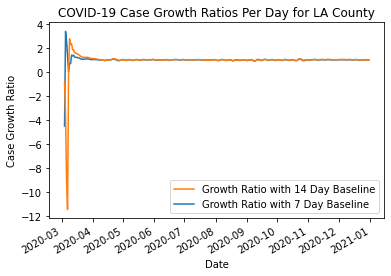

In [21]:
date = df_cases_LA['date'].astype('O')
fig, ax = plt.subplots()
ax.plot(date, df_cases_LA['growth_rate_7day'], label = "Growth Ratio with 7 Day Baseline")
ax.plot(date, df_cases_LA['growth_rate_14day'], label = "Growth Ratio with 14 Day Baseline")

# rotate and align the tick labels
fig.autofmt_xdate()

# fix date string
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')

# add labels
ax.set_title('COVID-19 Case Growth Ratios Per Day for LA County')
ax.set_xlabel('Date')
ax.set_ylabel('Case Growth Ratio')

# add legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1])

plt.show()

### Graph All Data

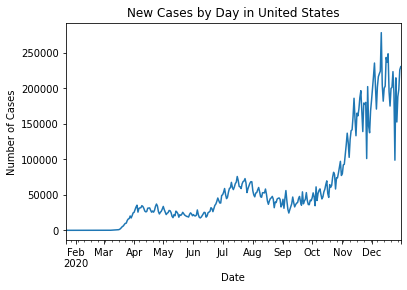

In [22]:
total_cases = df_cases.groupby('date').agg({'new_cases': 'sum'})
total_cases.plot(legend = None)
plt.title("New Cases by Day in United States")
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.show()

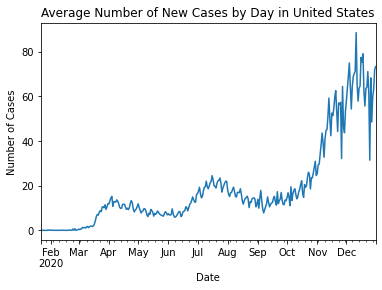

In [23]:
mean_num_cases = df_cases.groupby('date').agg({'new_cases': 'mean'})
mean_num_cases.plot(legend = None)
plt.title("Average Number of New Cases by Day in United States")
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.show()

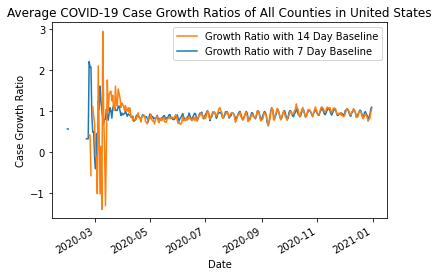

In [24]:
mean_growth_rate_7day = df_cases.groupby('date').agg({'growth_rate_7day': 'mean'}).reset_index()
mean_growth_rate_14day = df_cases.groupby('date').agg({'growth_rate_14day': 'mean'}).reset_index()
mean_growth_rate_7day = mean_growth_rate_7day.rename(columns = {'growth_rate_7day': 'mean_growth_rate_7day'})
mean_growth_rate_14day = mean_growth_rate_14day.rename(columns = {'growth_rate_14day': 'mean_growth_rate_14day'})

fig, ax = plt.subplots()
ax.plot(mean_growth_rate_7day['date'], mean_growth_rate_7day['mean_growth_rate_7day'], label = "Growth Ratio with 7 Day Baseline")
ax.plot(mean_growth_rate_14day['date'], mean_growth_rate_14day['mean_growth_rate_14day'], label = "Growth Ratio with 14 Day Baseline")

# rotate and align the tick labels
fig.autofmt_xdate()

# fix date string
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')

# add labels
ax.set_title('Average COVID-19 Case Growth Ratios of All Counties in United States')
ax.set_xlabel('Date')
ax.set_ylabel('Case Growth Ratio')

# add legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1])

plt.show()

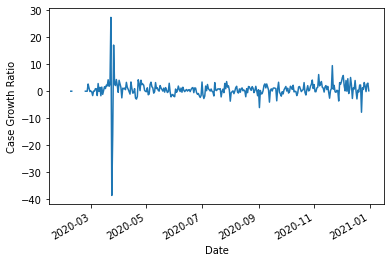

In [25]:
mean_growth_rate_of_change = df_cases.groupby('date').agg({'growth_rate_of_change': 'mean'}).reset_index()
mean_growth_rate_of_change = mean_growth_rate_of_change.rename(columns = {'growth_rate_of_change': 'mean_growth_rate_of_change'})

fig, ax = plt.subplots()
ax.plot(mean_growth_rate_of_change['date'], mean_growth_rate_of_change['mean_growth_rate_of_change'], label = "Growth Rate of Change")

# rotate and align the tick labels
fig.autofmt_xdate()

# fix date string
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')

ax.set_xlabel('Date')
ax.set_ylabel('Case Growth Ratio')

plt.show()

In [ ]:
df_cases_april = df_cases[(df_cases['date'] >= '2020-04-01') & (df_cases['date'] <= '2020-04-30')]
df_cases_april.to_csv('/content/drive/My Drive/Princeton/Independent Work/covid19/covid_data_april.csv')

In [ ]:
df_cases_december = df_cases[(df_cases['date'] >= '2020-12-01') & (df_cases['date'] <= '2020-12-26')]
df_cases_december.to_csv('/content/drive/My Drive/Princeton/Independent Work/covid19/covid_data_december.csv')

# Mobility Data
Load and prepare mobility data. Caculate mobility trends against a baseline from month of January.

## Load and Clean Data

In [ ]:
# load file
mobility_path = "./data/dot_mobility_dataset.csv"
df_mobility = pd.read_csv(mobility_path, parse_dates=[1])
df_mobility.info()
df_mobility.head()

In [ ]:
# remove all rows that are not "county" rows or have a date that is from 2019
df_mobility = df_mobility[(df_mobility['Date'] >= '2020-01-01') & (df_mobility['Level'] == 'County')].reset_index()
del df_mobility['index']
del df_mobility['Level']
df_mobility["Date"].min()

### Fix FIPS Code

In [ ]:
us_state_abbrev = {
    'AL': 'Alabama',
    'AK': 'Alaska',
    'AZ': 'Arizona',
    'AR': 'Arkansas',
    'CA': 'California',
    'CO': 'Colorado',
    'CT': 'Connecticut',
    'DC': 'District of Columbia',
    'DE': 'Delaware',
    'FL': 'Florida',
    'GA': 'Georgia',
    'HI': 'Hawaii',
    'ID': 'Idaho',
    'IL': 'Illinois',
    'IN': 'Indiana',
    'IA': 'Iowa',
    'KS': 'Kansas',
    'KY': 'Kentucky',
    'LA': 'Louisiana',
    'ME': 'Maine',
    'MD': 'Maryland',
    'MA': 'Massachusetts',
    'MI': 'Michigan',
    'MN': 'Minnesota',
    'MS': 'Mississippi',
    'MO': 'Missouri',
    'MT': 'Montana',
    'NE': 'Nebraska',
    'NV': 'Nevada',
    'NH': 'New Hampshire',
    'NJ': 'New Jersey',
    'NM': 'New Mexico',
    'NY': 'New York',
    'NC': 'North Carolina',
    'ND': 'North Dakota',
    'OH': 'Ohio',
    'OK': 'Oklahoma',
    'OR': 'Oregon',
    'PA': 'Pennsylvania',
    'RI': 'Rhode Island',
    'SC': 'South Carolina',
    'SD': 'South Dakota',
    'TN': 'Tennessee',
    'TX': 'Texas',
    'UT': 'Utah',
    'VT': 'Vermont',
    'VA': 'Virginia',
    'WA': 'Washington',
    'WV': 'West Virginia',
    'WI': 'Wisconsin',
    'WY': 'Wyoming',
}

In [ ]:
# change abbreviations to state name
df_mobility['State Postal Code'].replace(us_state_abbrev, inplace=True, regex=True)

# remove "county" from county name
df_mobility['County Name'] = df_mobility['County Name'].str.replace(' County', '', regex=True)

# rename columns
df_mobility = df_mobility.rename(columns = {'State Postal Code': 'State', 'County Name': 'County'})

# drop FIPS columns
del df_mobility['County FIPS']
del df_mobility['State FIPS']

df_mobility.head()

In [ ]:
df_mobility[(df_mobility['State'] == 'New York') & (df_mobility['Date'] == '2020-12-01')]

In [ ]:
df_mobility[(df_mobility['State'] == 'Rhode Island') & (df_mobility['Date'] == '2020-12-01')]

In [ ]:
# get fips from covid case dataset
df_fips = df_cases.drop_duplicates('fips')
df_fips = df_fips[['county', 'state', 'fips']]

# add metropolitan areas that were clumped together
df_fips = df_fips.append(pd.DataFrame(np.array([['Bristol', 'Rhode Island', '44002'],
                                      ['Kent', 'Rhode Island', '44002'],
                                      ['Newport', 'Rhode Island', '44002'],
                                      ['Providence', 'Rhode Island', '44002'],
                                      ['Washington', 'Rhode Island', '44002'],
                                      ['Bronx', 'New York', '36061'],
                                      ['Kings', 'New York', '36061'],
                                      ['New York', 'New York', '36061'],
                                      ['Queens', 'New York', '36061'],
                                      ['Richmond', 'New York', '36061'],
                                      ['Cass', 'Missouri', '29095'],
                                      ['Clay', 'Missouri', '29095'],
                                      ['Jackson', 'Missouri', '29095'],
                                      ['Platte', 'Missouri', '29095']]),
                            columns = ['county', 'state', 'fips']))
df_fips = df_fips.reset_index()
df_fips

In [ ]:
# merge with mobility data
df_mobility = df_mobility.merge(df_fips, left_on = ['State', 'County'], right_on = ['state', 'county'])
del df_mobility['county']
del df_mobility['state']
df_mobility = df_mobility.rename(columns = {'fips': 'FIPS'})
df_mobility.head()

In [ ]:
df_mobility[df_mobility['FIPS'] == '36061']

## Subset Data into Baseline and Pandemic

In [ ]:
# subset month of January as baseline for movement trends
df_mobility['Day'] = df_mobility['Date'].dt.day
df_mobility_baseline = df_mobility[(df_mobility['Date'] >= '2020-01-01') & (df_mobility['Date'] <= '2020-01-31')]
df_mobility_pandemic = df_mobility[(df_mobility['Date'] >= '2020-02-01')]

In [ ]:
# populate pandemic dataframe with the corresponding baseline (number of trips on that day), according to the county name, state, and day of the month
df_mobility_baseline_compact = df_mobility_baseline[['State', 'County', 'Day', 'Number of Trips']]
df_mobility_pandemic = df_mobility_pandemic.merge(df_mobility_baseline_compact, left_on=['State', 'County', 'Day'], right_on=['State', 'County', 'Day'])
df_mobility_pandemic.rename(columns = {'Number of Trips_x': 'Number of Trips during Pandemic', 'Number of Trips_y': 'Number of Trips Baseline'}, inplace = True)

### Calculate Total Population Being Tracked

In [ ]:
sum = df_mobility_pandemic[['Date', 'Population Staying at Home', 'Population Not Staying at Home']].groupby("Date").sum()
sum


In [ ]:
total_population = sum['Population Staying at Home'] + sum['Population Not Staying at Home']
total_population.mean()

## Compute Mobility Ratios

### Average Baseline of January

In [ ]:
baseline_value = df_mobility_baseline_compact['Number of Trips'].mean()
baseline_value

In [ ]:
# calculate mobility ratio
df_mobility_pandemic['mobility_ratio_avg_baseline'] = df_mobility_pandemic['Number of Trips during Pandemic']/baseline_value
df_mobility_pandemic

### Corresponding Day Baseline

In [ ]:
# calculate mobility ratio
df_mobility_pandemic['mobility_ratio_corres_baseline'] = df_mobility_pandemic['Number of Trips during Pandemic']/df_mobility_pandemic['Number of Trips Baseline']
df_mobility_pandemic

### Relative Mobility Ratio

In [ ]:
df_mobility_pandemic['mobility_ratio_relative_7day'] = np.log(df_mobility_pandemic['Number of Trips during Pandemic'].rolling(3).sum() / 3) / np.log(df_mobility_pandemic['Number of Trips during Pandemic'].rolling(7).sum() / 7)
df_mobility_pandemic['mobility_ratio_relative_14day'] = np.log(df_mobility_pandemic['Number of Trips during Pandemic'].rolling(3).sum() / 3) / np.log(df_mobility_pandemic['Number of Trips during Pandemic'].rolling(14).sum() / 14)
df_mobility_pandemic

### Graph Mobility Ratio

In [ ]:
mean_mobility_ratio = df_mobility_pandemic.groupby('Date').agg({'mobility_ratio_avg_baseline': 'mean',
                                                                'mobility_ratio_corres_baseline': 'mean'})
mean_mobility_ratio.plot()
plt.title('Average Mobility Ratios with January Baseline in United States')
plt.xlabel('Date')
plt.ylabel('Mobility Ratio')
plt.legend(labels = ['mobility ratio with averaged Jan baseline',
                     'mobility ratio with corresonding Jan day baseline'],
           loc='upper left', bbox_to_anchor=(0.05, -0.20))
plt.show()

In [ ]:
mean_mobility_ratio = df_mobility_pandemic.groupby('Date').agg({'mobility_ratio_relative_7day': 'mean',
                                                                'mobility_ratio_relative_14day': 'mean'})
mean_mobility_ratio.plot()
plt.title('Average Relative Mobility Ratios in United States')
plt.xlabel('Date')
plt.ylabel('Mobility Ratio')
plt.legend(labels = ['mobility ratio with 7 day incubation baseline',
                     'mobility ratio with 14 day incubation baseline'],
           loc='upper left', bbox_to_anchor=(0.05, -0.20))
plt.show()

In [ ]:
df_mobility_april = df_mobility_pandemic[(df_mobility_pandemic['Date'] >= '2020-04-01') & (df_mobility_pandemic['Date'] <= '2020-04-30')]
df_mobility_april.to_csv('/content/drive/My Drive/Princeton/Independent Work/mobility/mobility_data_april.csv')

In [ ]:
df_mobility_december = df_mobility_pandemic[(df_mobility_pandemic['Date'] >= '2020-12-01') & (df_mobility_pandemic['Date'] <= '2020-12-26')]
df_mobility_december.to_csv('/content/drive/My Drive/Princeton/Independent Work/mobility/mobility_data_december.csv')

# Compute Regression Line Between Mobility Ratio and Case Growth Ratio

## Merge Mobility Ratio and Growth Ratio into One Dataframe

In [ ]:
# cut off all entries after earliest 'last date'
max_date = min(df_mobility_pandemic['Date'].max(), df_cases['date'].max())
print(max_date)

df_cases = df_cases[df_cases['date'] <= max_date]
df_mobility_pandemic = df_mobility_pandemic[df_mobility_pandemic['Date'] <= max_date]

In [ ]:
df_mobility_ratio = df_mobility_pandemic[['Date', 'State', 'County', 'mobility_ratio_avg_baseline', 'mobility_ratio_corres_baseline', 'mobility_ratio_relative_7day', 'mobility_ratio_relative_14day']]
df_growth_ratio = df_cases[['date', 'state', 'county', 'fips', 'growth_rate_7day', 'growth_rate_14day', 'growth_rate_of_change']]
df_regression = df_growth_ratio.merge(df_mobility_ratio, left_on=['date', 'state', 'county'], right_on=['Date', 'State', 'County'])
del df_regression['Date']
del df_regression['State']
del df_regression['County']
df_regression = df_regression.dropna(axis='rows')

df_regression

### Check that Merge Happened Correctly

In [ ]:
df_regression[(df_regression['date'] == '2020-12-26') & (df_regression['state'] == ('California'))].sort_values(by=['county'])

In [ ]:
df_cases[(df_cases['fips'] == '06037') & (df_cases['date'] >= '2020-12-01') & (df_cases['date'] <= '2020-12-14')]

In [ ]:
df_mobility_pandemic[(df_mobility_pandemic['Date'] == '2020-12-26') & (df_mobility_pandemic['State'] == 'California')].sort_values(by=['County'])

## Graph Case Growth vs. Mobility Ratios

In [ ]:
plt.plot(df_regression['mobility_ratio_corres_baseline'].to_numpy(), df_regression['growth_rate_7day'].to_numpy(), 'o')
plt.plot(df_regression['mobility_ratio_corres_baseline'].to_numpy(), df_regression['growth_rate_14day'].to_numpy(), 'o')
plt.xlabel('Mobility Ratios with Corresonding January Day Baseline')
plt.ylabel('COVID-19 Cases Growth Rates')
plt.legend(labels = ['case growth rate with 7 day baseline',
                     'case growth rate with 14 day baseline'])
plt.show()

In [ ]:
plt.plot(df_regression['mobility_ratio_avg_baseline'].to_numpy(), df_regression['growth_rate_7day'].to_numpy(), 'o')
plt.plot(df_regression['mobility_ratio_avg_baseline'].to_numpy(), df_regression['growth_rate_14day'].to_numpy(), 'o')
plt.title('COVID-19 Cases Growth Rates vs. Mobility Ratios')
plt.xlabel('Mobility Ratios with Averaged January Mobility Baseline')
plt.ylabel('COVID-19 Cases Growth Rates')
plt.legend(labels = ['case growth rate with 7 day baseline',
                     'case growth rate with 14 day baseline'])
plt.show()

In [ ]:
plt.plot(df_regression['mobility_ratio_relative_7day'].to_numpy(), df_regression['growth_rate_7day'].to_numpy(), 'o')
plt.plot(df_regression['mobility_ratio_relative_7day'].to_numpy(), df_regression['growth_rate_14day'].to_numpy(), 'o')
plt.xlabel('Relative Mobility Ratios')
plt.ylabel('COVID-19 Cases Growth Rates')
plt.legend(labels = ['case growth rate with 7 day baseline',
                     'case growth rate with 14 day baseline'])
plt.show()

In [ ]:
plt.plot(df_regression['mobility_ratio_corres_baseline'].to_numpy(), df_regression['growth_rate_of_change'].to_numpy(), 'o')
plt.xlabel('Mobility Ratios to Corresponding January Day Baseline')
plt.ylabel('COVID-19 Cases Growth Rates')
plt.show()

## Calculate Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from scipy.stats import describe
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [ ]:
# introduce time lag between mobility and covid case data
correlations = []

# first check against 7 day growth rate
for i in range(0, 14):
  df_regression['growth_rate_7day'] = df_regression.groupby('fips')['growth_rate_7day'].shift(1)
  df_regression = df_regression.dropna(axis='rows')
  
  result_avg_baseline = linregress(df_regression['mobility_ratio_avg_baseline'].to_numpy(), df_regression['growth_rate_7day'].to_numpy())
  result_corres_baseline = linregress(df_regression['mobility_ratio_corres_baseline'].to_numpy(), df_regression['growth_rate_7day'].to_numpy())
  result_relative_7day = linregress(df_regression['mobility_ratio_relative_7day'].to_numpy(), df_regression['growth_rate_7day'].to_numpy())
  result_relative_14day = linregress(df_regression['mobility_ratio_relative_14day'].to_numpy(), df_regression['growth_rate_7day'].to_numpy())

  correlations.append([result_avg_baseline.rvalue, result_corres_baseline.rvalue, result_relative_7day.rvalue, result_relative_14day.rvalue])

  print("Correlations with time lag ", i)
  print("  averaged Jan baseline mobility ratio: ", result_avg_baseline.rvalue)
  print("  corresponding Jan day baseline mobility ratio: ", result_corres_baseline.rvalue)
  print("  relative with 7 day baseline mobility ratio: ", result_relative_7day.rvalue)
  print("  relative with 14 day baseline mobility ratio: ", result_relative_14day.rvalue)

In [ ]:
plt.plot([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], correlations, 'o')
plt.title('Correlation between Growth Rate (7 Day) and Mobility Ratio vs. Time Lag')
plt.xlabel('Time Lag in Days')
plt.ylabel('Correlation')
plt.legend(labels = ['mobility ratio with averaged Jan baseline',
                     'mobility ratio with corresponding Jan day baseline',
                     'relative mobility ratio with 7 day baseline',
                     'relative mobility ratio with 14 day baseline'
                     ], loc='upper left', bbox_to_anchor=(0.05, -0.15))
plt.show()

In [ ]:
# introduce time lag between mobility and covid case data
correlations = []

# first check against 14 day growth rate
for i in range(0, 14):
  df_regression['growth_rate_14day'] = df_regression.groupby('fips')['growth_rate_14day'].shift(1)
  df_regression = df_regression.dropna(axis='rows')
  
  result_avg_baseline = linregress(df_regression['mobility_ratio_avg_baseline'].to_numpy(), df_regression['growth_rate_14day'].to_numpy())
  result_corres_baseline = linregress(df_regression['mobility_ratio_corres_baseline'].to_numpy(), df_regression['growth_rate_14day'].to_numpy())
  result_relative_7day = linregress(df_regression['mobility_ratio_relative_7day'].to_numpy(), df_regression['growth_rate_14day'].to_numpy())
  result_relative_14day = linregress(df_regression['mobility_ratio_relative_14day'].to_numpy(), df_regression['growth_rate_14day'].to_numpy())

  correlations.append([result_avg_baseline.rvalue, result_corres_baseline.rvalue, result_relative_7day.rvalue, result_relative_14day.rvalue])

  print("Correlations with time lag ", i)
  print("  averaged Jan baseline mobility ratio: ", result_avg_baseline.rvalue)
  print("  corresponding Jan day baseline mobility ratio: ", result_corres_baseline.rvalue)
  print("  relative with 7 day baseline mobility ratio: ", result_relative_7day.rvalue)
  print("  relative with 14 day baseline mobility ratio: ", result_relative_14day.rvalue)

In [ ]:
plt.plot([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], correlations, 'o')
plt.title('Correlation between Growth Rate (14 Day) and Mobility Ratio vs. Time Lag')
plt.xlabel('Time Lag in Days')
plt.ylabel('Correlation')
plt.legend(labels = ['mobility ratio with averaged Jan baseline',
                     'mobility ratio with corresponding Jan day baseline',
                     'relative mobility ratio with 7 day baseline',
                     'relative mobility ratio with 14 day baseline'
                     ], loc='upper left', bbox_to_anchor=(1.05, 1))
plt.show()

In [ ]:
# introduce time lag between mobility and covid case data
correlations = []

# first check against 14 day growth rate
for i in range(0, 14):
  df_regression['growth_rate_of_change'] = df_regression.groupby('fips')['growth_rate_of_change'].shift(1)
  df_regression = df_regression.dropna(axis='rows')
  
  result_avg_baseline = linregress(df_regression['mobility_ratio_avg_baseline'].to_numpy(), df_regression['growth_rate_of_change'].to_numpy())
  result_corres_baseline = linregress(df_regression['mobility_ratio_corres_baseline'].to_numpy(), df_regression['growth_rate_of_change'].to_numpy())
  result_relative_7day = linregress(df_regression['mobility_ratio_relative_7day'].to_numpy(), df_regression['growth_rate_of_change'].to_numpy())
  result_relative_14day = linregress(df_regression['mobility_ratio_relative_14day'].to_numpy(), df_regression['growth_rate_of_change'].to_numpy())

  correlations.append([result_avg_baseline.rvalue, result_corres_baseline.rvalue, result_relative_7day.rvalue, result_relative_14day.rvalue])

  print("Correlations with time lag ", i)
  print("  averaged Jan baseline mobility ratio: ", result_avg_baseline.rvalue)
  print("  corresponding Jan day baseline mobility ratio: ", result_corres_baseline.rvalue)
  print("  relative with 7 day baseline mobility ratio: ", result_relative_7day.rvalue)
  print("  relative with 14 day baseline mobility ratio: ", result_relative_14day.rvalue)

In [ ]:
plt.plot([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], correlations, 'o')
plt.title('Correlation between Growth Rate of Change and Mobility Ratio vs. Time Lag')
plt.xlabel('Time Lag in Days')
plt.ylabel('Correlation')
plt.legend(labels = ['mobility ratio with averaged Jan baseline',
                     'mobility ratio with corresponding Jan day baseline',
                     'relative mobility ratio with 7 day baseline',
                     'relative mobility ratio with 14 day baseline'
                     ], loc='upper left', bbox_to_anchor=(0.05, -0.15))
plt.show()